# PSWF Calculation  (by Anna Scaife)

This notebook calculates an over-sampled Prolate Spheroidal Wave Function (PSWF), which is the most commonly used anti-aliasing kernel for convolutional gridding during imaging.

Note: it may be better to use a Kaiser-Bessel function as in medical imaging.

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as pl

In [4]:
def calc_pswf(vnu):
    
    """
    Evaluates the PROLATE SPHEROIDAL WAVEFUNCTION with 
    m=6, alpha = 1 from Schwab, Indirect Imaging (1984). 
    
    Code adapted Anna's f90 PROFILE (gridder.f90) code 
    which was adapted from Tim Cornwell's C++ SphFuncVisGridder 
    developed for CONRAD for ASKAP. **This seems to be commented
    out of the currect ASKAPsoft code... not sure why**
  
    """

    n_p = 4
    n_q = 2
    
    p = np.zeros((2,5))
    q = np.zeros((2,3))
    
    p[0,0] = 8.203343e-2
    p[0,1] = -3.644705e-1
    p[0,2] = 6.278660e-1
    p[0,3] = -5.335581e-1
    p[0,4] = 2.312756e-1
    p[1,0] = 4.028559e-3
    p[1,1] = -3.697768e-2
    p[1,2] = 1.021332e-1
    p[1,3] = -1.201436e-1
    p[1,4] = 6.412774e-2

    q[0,0] = 1.0000000
    q[0,1] = 8.212018e-1
    q[0,2] = 2.078043e-1
    q[1,0] = 1.0000000
    q[1,1] = 9.599102e-1
    q[1,2] = 2.918724e-1

    value = 0.
        
    if ((vnu>=0.) and (vnu<0.75)):
        part = 0
        nuend = 0.75
    elif ((vnu>=0.75) and (vnu<=1.)):
        part = 1
        nuend = 1.0
    else:
        value = 0.
        # nasty fortran-esque exit statement:
        return value
   
    top = p[part,0]
    bot = q[part,0]
    delnusq = vnu**2 - nuend**2
      
    for k in range(1,n_p+1):
        factor = delnusq**k
        top += p[part,k]*factor
      
    for k in range(1,n_q+1):
        factor = delnusq**k
        bot += q[part,k]*factor
      
      
    if (bot!=0.):
        value = top/bot
    else:
        value = 0.
      
      
    if (value<0.): value = 0.
      
    return value

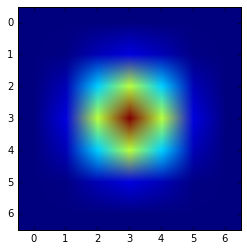

In [5]:
def make_oversampled_pswf():
    """
    Note: this is the PSWF in uv-space
    """
    
    # ------------------------------------------------------- #
    # the following stuff probably shouldn't be hard-coded...
    support = 3
    oversample = 128
    csize = 2 * support + 1  # 7
    ccentre = support  # 3 for 0-indexed array
    nplanes = oversample * oversample
    # ------------------------------------------------------- #
    
    
    spconvfunc = np.zeros((nplanes, csize, csize))
    
    for fracv in range(0, oversample):
        for fracu in range(0, oversample):
            
            plane = fracu + (oversample * fracv)
            spconvfunc[plane, :, :] = 0.
            
            for ix in range(0, csize):
                nux = np.abs(float(oversample * (ix - ccentre) + fracu)) / float(support * oversample)
                fx = calc_pswf(nux)
                fx *= (1. - nux ** 2)
                
                for iy in range(0, csize):
                    nuy = np.abs(float(oversample * (iy - ccentre) + fracv)) / float(support * oversample)
                    fy = calc_pswf(nuy)
                    fy *= (1. - nuy ** 2)
                    
                    spconvfunc[plane, ix, iy] = fx * fy
    
    return spconvfunc

spconvfunc = make_oversampled_pswf()

pl.subplot(111)
pl.imshow(spconvfunc[0, :, :])
pl.show()
